<a href="https://colab.research.google.com/github/gridface/AngularTemplate-Recipes/blob/master/simple_stock_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#example

#you can make this faster by shedding the series and just returning values
# np.where(
# df['status_at_time_of_lead'] == 'None',
# df['current_status'],
# df['status_at_time_of_lead'])

# func = emps['Hire'] = np.where(
#     emps['YearsExperience'] > 30 ,
#     emps['YearsExperience']+40,
#     emps['YearsExperience']-5)


#np.select() will allow you to evaluate 2+ conditions efficiently

# conditions = [
#     emps['YearsExperience'] > 15,
#     (emps['Age'] > 50) & (emps['Gender'] == "f"),
#     emps['Name'].str.startswith('s')
# ]

# choices = [
#     'Second Interview',
#     'Hire',
#     "Call"
# ]

# bigFunc = emps['Hire'] = np.select(conditions, choices, default='Pass')

# pay special attention to the order of execution here - it does not re-evaluate
# notice how everyone with years of experience over 10 gets a second interview


########           ##########
#### NOTEBOOK SETUP #########
########           ##########
# use this line to install the yahoo finance api library. 
# Note that the official yahoo finance api is defunct, and this new library called "yfinance" has taken its place
!pip install yfinance
# once it is installed, we can import it like any other installed library
import yfinance as yf
#pandas, numpy and matplotlib libraries are already part of colab, so we just import them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#############################
########### Utility Functions 
#############################
####  these could eventually be pulled out into a separate file,
####    but for now we keep them at the top of this notebook for convenience

## function name: adder
## description: this adds extra columns full of zeros for additional processing
## Usage:
## my_data = adder(my_data,5) #this addes 5 new colums to the my_data array
def adder(Data, times):
  for i in range(1,times + 1):
    z = np.zeros((len(Data),1),dtype = float)
    Data = np.append(Data,z,axis = 1)
  return Data


## function name: deleter
## description: deletes a specified number of columns from an array
## usage: my_data = deleter(my_data,5,2) #deletes 2 columns starting from the 5th column
def deleter(Data,index,times):
  for i in range(1,times+1):
    Data = np.delete(Data, index, axis = 1)
  return Data

## function name: jump
## description: deletes a specified number of rows from an array
## usage: my_data = jump(my_data,10) #deletes first 10 rows of an array
def jump(Data,jump):
  Data = Data[jump:,]
  return Data

## function name: ma
## description: inserts moving average data into a specified column
## usage: my_data = ma(my_data,20,3,4) #this inserts a 20 period moving average
## based on column 4 (likely the closing price) into the fifth column
## (an empty column you have prepared with the adder function)
from pandas.core.base import DataError
def ma(Data, lookback, what, where):
  for i in range(len(Data)):
    try:
      Data[i, where] = (Data[i - lookback +1:i + 1, what].mean())
    except IndexError:
      pass
  return Data
## function name: signal
## description: populates buy/sell columns following crossovers from ma 
## usage: signal(my_data,3,4,5,6) # takes the closing data (col 3) and the
## ma data (column 4) and populates the prepared columns (col 5 and 6) 
## with a signal indicator which is 1 for buy and -1 for sell
## NOTE: this came from a book, and i think we can make this faster with np.where()


def signal(Data, closing, moving_average, buy, sell):
  for i in range(len(Data)):
    if Data[i,closing] > Data[i,moving_average] and Data[i - 1, closing] < Data[i - 1, moving_average]:
      Data[i,buy]=1
    if Data[i,closing] < Data[i,moving_average] and Data[i - 1, closing] < Data[i - 1, moving_average]:
      Data[i,sell]=-1
  return Data

## function name: volatility
## description: calculates the volatility (ie, standard deviation) of the 
## running closing price and places it in a specified column
## Usage: my_data = volatility(my_data,10,3,4)
##  calculates a 10-period volatility score for closing prices (3) and places them in column 4
def volatility(Data,lookback,what,where):
  for i in range(len(Data)):
    try:
      Data[i,where] = (Data[i-lookback + 1:i + 1, what].std())
    except IndexError:
      pass
  return Data

## function name: normalizer
## description: 
## 
## Usage: my_data = normalizer(my_data,5,3,4)
##  
def normalizer(Data,lookback,what,where):
  for i in range(len(Data)):
    try:
      Data[i,where] = (Data[i,what] - min(Data[i-lookback + 1:i+1,
        what]))/(max(Data[i-lookback + 1:i + 1,what]) - min(Data[i-lookback+1:i+1,what]))
    except ValueError:
      pass
  Data[:,where] = Data[:,where]*100
  Data = jump(Data,lookback)
  return Data

## function name: normalizer
## description: returns the equity curve of a strategy against a stock
#honestly, i am not sure what these columns are exactly, nor how to use the inputs
#0: buy profit
#1: sell profit
#2: cumulative percentage
#3: cumulative profits with initial investments
def indexer(Data,expected_cost,lot,investment):
  #charting portfolio evolution
  # indexer = Data[:,first_column_of_holding_period:second_column_of_holding_period+1]
  indexer = Data[:,7:8+1] 
  #creating a combined array for long and short returns
  z = np.zeros((len(Data),1),dtype=float)
  indexer=np.append(indexer,z,axis=1)
  #combining returns
  for i in range(len(indexer)):
    try:
      if indexer[i,0]!=0:
        indexer[i,2] = indexer[i,0] - (expected_cost/lot)

      if indexer[i,1]!=0:
        indexer[i,2] = indexer[i,0] - (expected_cost/lot)
    except IndexError:
      pass
  #switching to monetary values
  indexer[:,2] = indexer[:,2]*lot
  #creating a portfolio balance array
  indexer = np.append(indexer,z,axis=1)
  indexer[:,3] = investment
  #Adding returns to the balance
  for i in range(len(indexer)):
    indexer[i,3] = indexer[i-1,3]+(indexer[i,2])
  indexer = np.array(indexer)
  return np.array(indexer)

#function name: rsi
#description: provides relative strength indicator for a stock
def rsi(Data, lookback, close, where, width = 1, genre = 'Smoothed'):
    
    # Adding a few columns
    Data = adder(Data, 7)
    
    # Calculating Differences
    for i in range(len(Data)):
        
        Data[i, where] = Data[i, close] - Data[i - width, close]
     
    # Calculating the Up and Down absolute values
    for i in range(len(Data)):
        
        if Data[i, where] > 0:
            
            Data[i, where + 1] = Data[i, where]
            
        elif Data[i, where] < 0:
            
            Data[i, where + 2] = abs(Data[i, where])
            
    # Calculating the Smoothed Moving Average on Up and Down
    #absolute values    
    if genre == 'Smoothed': 
                   
      lookback = (lookback * 2) - 1 # From exponential to smoothed
      Data = ema(Data, 2, lookback, where + 1, where + 3)
      Data = ema(Data, 2, lookback, where + 2, where + 4)
    
    if genre == 'Simple':  
                  
      Data = ma(Data, lookback, where + 1, where + 3)
      Data = ma(Data, lookback, where + 2, where + 4)
    
    # Calculating the Relative Strength
    Data[:, where + 5] = Data[:, where + 3] / Data[:, where + 4]
    
    # Calculate the Relative Strength Index
    Data[:, where + 6] = (100 - (100 / (1 + Data[:, where + 5])))  
    
    # Cleaning
    Data = deleter(Data, where, 6)
    Data = jump(Data, lookback)                        
    return Data
#We need to define the primal manipulation functions first in order to use the RSI’s function on OHLC data arrays.


# function name: performance
# description: prints out 
def performance(indexer, Data, name):
  
  # Profitability index
  indexer = np.delete(indexer, 0, axis = 1)
  indexer = np.delete(indexer, 0, axis = 1)
  
  profits = []
  losses  = []
  np.count_nonzero(Data[:, 7])
  np.count_nonzero(Data[:, 8])
  
  for i in range(len(indexer)):
      
      if indexer[i, 0] > 0:
          value    = indexer[i, 0]
          profits  = np.append(profits, value)
          
      if indexer[i, 0] < 0:
          value    = indexer[i, 0]
          losses   = np.append(losses, value)
  
  # Hit ratio calculation
  hit_ratio = round((len(profits) / (len(profits) + len(losses))) * 100, 2)
  
  realized_risk_reward = round(abs(profits.mean() / losses.mean()), 2)
  
  # Expected and total profits / losses
  expected_profits = np.mean(profits)
  expected_losses  = np.abs(np.mean(losses))
  total_profits    = round(np.sum(profits), 3)
  total_losses     = round(np.abs(np.sum(losses)), 3)
  
  # Expectancy
  expectancy    = round((expected_profits * (hit_ratio / 100)) \
                  - (expected_losses * (1 - (hit_ratio / 100))), 2)
      
  # Largest Win and Largest Loss
  largest_win = round(max(profits), 2)
  largest_loss = round(min(losses), 2)    # Total Return
  indexer = Data[:, 10:12]    
  
  # Creating a combined array for long and short returns
  z = np.zeros((len(Data), 1), dtype = float)
  indexer = np.append(indexer, z, axis = 1)
  
  # Combining Returns
  for i in range(len(indexer)):
      try:    
        if indexer[i, 0] != 0:
            indexer[i, 2] = indexer[i, 0] - (expected_cost / lot)
              
        if indexer[i, 1] != 0:
            indexer[i, 2] = indexer[i, 1] - (expected_cost / lot)
      except IndexError:
          pass
      
  # Switching to monetary values
  indexer[:, 2] = indexer[:, 2] * lot
  
  # Creating a portfolio balance array
  indexer = np.append(indexer, z, axis = 1)
  indexer[:, 3] = investment 
  
  # Adding returns to the balance    
  for i in range(len(indexer)):
  
      indexer[i, 3] = indexer[i - 1, 3] + (indexer[i, 2])
  
  indexer = np.array(indexer)
  
  total_return = (indexer[-1, 3] / indexer[0, 3]) - 1
  total_return = total_return * 100
  
  
  print('-----------Performance-----------', name)
  print('Hit ratio       = ', hit_ratio, '%')
  print('Net profit      = ', '$', round(indexer[-1, 3] - indexer[0, 3], 2))
  print('Expectancy      = ', '$', expectancy, 'per trade')
  print('Profit factor   = ' , round(total_profits / total_losses, 2)) 
  print('Total Return    = ', round(total_return, 2), '%')
  print('')    
  print('Average Gain    = ', '$', round((expected_profits), 2), 'per trade')
  print('Average Loss    = ', '$', round((expected_losses * -1), 2), 'per trade')
  print('Largest Gain    = ', '$', largest_win)
  print('Largest Loss    = ', '$', largest_loss)    
  print('')
  print('Realized RR     = ', realized_risk_reward)
  print('Minimum         =', '$', round(min(indexer[:, 3]), 2))
  print('Maximum         =', '$', round(max(indexer[:, 3]), 2))
  print('Trades          =', len(profits) + len(losses))


In [15]:

# conditions = [
#     emps['YearsExperience'] > 15,
#     (emps['Age'] > 50) & (emps['Gender'] == "f"),
#     emps['Name'].str.startswith('s')
# ]

# choices = [
#     'Second Interview',
#     'Hire',
#     "Call"
# ]

# bigFunc = emps['Hire'] = np.select(conditions, choices, default='Pass')

def better_signal(Data, closing, moving_average, buy, sell):
  for i in range(len(Data)):

    conditions = [
        Data[i,closing] > Data[i,moving_average] and Data[i - 1, closing] < Data[i - 1, moving_average],
        Data[i,closing] < Data[i,moving_average] and Data[i - 1, closing] < Data[i - 1, moving_average]   
    ]

    choices = [
        Data[i,buy]==1,
        Data[i,sell]==-1,
    ]

    np.select(conditions, choices)
  return Data

In [16]:
#####
## SET YOUR VARIABLES
#####

# choose your stock
stock = "aapl"
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
custom_period = "1y"
# Moving average period
my_ma = 10


In [17]:
#####
## CREATE THE DATASET
#####

#Call the yfinance api. for productionm we may want to switch this to quandl
# https://data.nasdaq.com/databases/RTAT/pricing/plans
ticker = yf.Ticker(stock)
history = ticker.history(period=custom_period)
# history.columns
# Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

#Create a numpy array of OHLC data
#Even though I am referencing column numbers, (also known as "fields" (or "series" in a dataset)), 
#remember that these are 0 based, i.e. the first column is number 0
history_array = history[['Open', 'High', 'Low', 'Close']].to_numpy()

#lets add some empty columns to our array so we can run our moving average calculations.
#note: you need to assign the existing array to the function, otherwise the function just creates a copy of the array with the new columns
history_array = adder(history_array,5)

#we can check to make sure we added the number of columns we wanted to. the first number is the x axis (the rows) and the second number is the y axis (the columns)
#our numpy array should look like this when its populated (for a total of 9 columns):
# [0]: Open
# [1]: High
# [2]: Low
# [3]: Close
# [4]: moving average (20 day or whatever)
# [5]: buy signal
# [6]: sell signal
# [7]: buy return
# [8]: sell return

#history_array.shape
#(254, 9)

#data check to see that we pulled in our moving average (just the first 20 rows)
#history_array[:20,[3,4,5]]

#lets insert our 20 day moving average in column 4
history_array = ma(history_array,my_ma,3,4)
#since you are doing a moving average on the last i values, you will need to 
#delete out the first i number of records to make a useful chart
#history_array = jump(history_array,my_ma)
#lets populate columns 5 and 6 with our buy/sell signals

# history_array = signal(history_array,3,4,5,6)
history_array = better_signal(history_array,3,4,5,6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
history_array.shape

(253, 9)

In [19]:

## function name: holding
## description: uses the buy/sell bu/sell signals to backtest returns 
## usage: holding(my_data,buy,sell,buy_return,sell_return) 
## this takes the buy data (col 5) and sell data (col 6) then populates the 
## prepared columns (7 and 8) with estimated return for buys and sells
## NOTE: this came from a book, and i think we can make this faster with np.where()
def holding(Data, buy, sell, buy_return, sell_return):
  try:
    for i in range(len(Data)):
      if Data[i,buy] ==1:
        for a in range(i + 1, i + 1000):
          if Data[a,buy]!=0 or Data[a,sell]!=0:
            Data[a,buy_return]= (Data[a,3] - Data[i,3])
            break
          else:
            continue
      elif Data[i,sell] == -1:
        for a in range(i + 1, i + 1000):
          if Data[a,buy]!=0 or Data[a,sell]!=0:
            Data[a,sell_return]= (Data[i,3] - Data[a,3])
            break
          else:
            continue
  except IndexError:
      pass
#holding(my_data,buy,sell,buy_return,sell_return)
holding(history_array,5,6,7,8)

In [13]:
history_array

array([[131.00139   , 132.77087184, 130.29559346, ...,   0.        ,
          0.        ,   0.        ],
       [131.25985116, 133.27787111, 131.05110042, ...,   0.        ,
          0.        ,   0.        ],
       [130.41487425, 130.71310475, 125.95139768, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [155.91000366, 159.78999329, 155.38000488, ...,  -1.        ,
          0.        ,   0.22999573],
       [159.25      , 164.52000427, 158.92999268, ...,   0.        ,
          0.        ,  -7.06999207],
       [161.83999634, 166.19999695, 157.25      , ...,   0.        ,
          0.        ,   0.        ]])

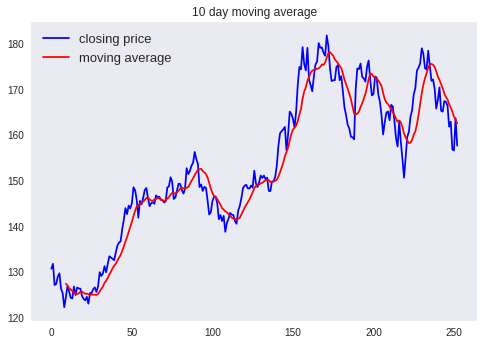

In [20]:
#lets plot it!
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.plot(history_array[:,3], color = 'blue', label = 'closing price')
plt.plot(history_array[:,4], color = 'red', label = 'moving average')
plt.grid()
plt.title(str(my_ma)+ ' day moving average')
plt.legend(fontsize = 13)
plt.show()

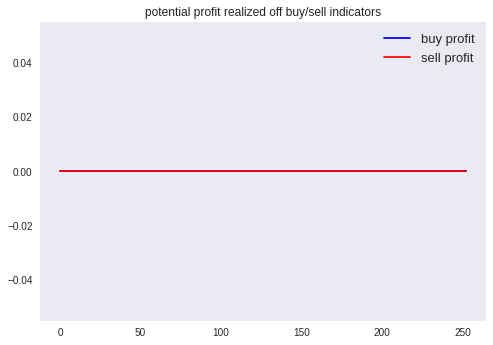

In [21]:
#lets plot it!
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.plot(history_array[:,7], color = 'blue', label = 'buy profit')
plt.plot(history_array[:,8], color = 'red', label = 'sell profit')
plt.grid()
plt.title('potential profit realized off buy/sell indicators')
plt.legend(fontsize = 13)
plt.show()

In [ ]:
# Using the function for a 0.1 lot strategy on $1000 investment
lot           = 10
expected_cost = 0.5 * (lot / 1000) # 0.5 pip spread
investment    = 1000                  
equity_curve = indexer(history_array,expected_cost,lot,investment)

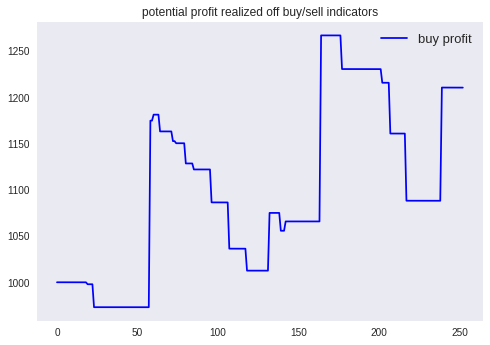

In [ ]:
#lets plot it!
import matplotlib.pyplot as plt
plt.style.use("seaborn")

plt.plot(equity_curve[:,3], color = 'blue', label = 'buy profit')
plt.grid()
plt.title('potential profit realized off buy/sell indicators')
plt.legend(fontsize = 13)
plt.show()

In [ ]:
# Using the function
performance(indexer, history_array, 'aapl')

AxisError: ignored

In [ ]:
adder(history_array,1)

array([[134.21229443, 134.60994015, 133.3176181 , ...,   0.        ,
          0.        ,   0.        ],
       [133.51643884, 134.22225054, 132.29371043, ...,   0.        ,
          0.        ,   0.        ],
       [135.66368462, 136.26014566, 131.66743206, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [166.46000671, 167.86999512, 161.5       , ...,   0.        ,
          4.63000488,   0.        ],
       [161.11999512, 163.16999817, 158.46000671, ...,   0.        ,
         -1.0900116 ,   0.        ],
       [162.25      , 162.33999634, 156.72000122, ...,   0.        ,
          6.08000183,   0.        ]])

In [ ]:
history_array.shape

(253, 9)

In [ ]:
# rsi(Data, lookback, close, where, width = 1, genre = 'Smoothed')
rsi = rsi(history_array,20,3,8,width=1,genre="Simple")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
